In [1]:
!pip install stellargraph
!pip install livelossplot

In [2]:
import json
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import tensorflow as tf
import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics
from livelossplot import PlotLossesKeras
import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Hinsge

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Hinsge


In [4]:
csv_1 = 'metadata.csv'
features_meta = pd.read_csv(csv_1)
features_meta = features_meta.sort_values(by = 'song_id')
# features_meta = features_meta[features_meta['song_id'].isin(set(genre['song_id']))]
print(features_meta.shape)

csv_2 = 'audio_features.csv'
features_raw = pd.read_csv(csv_2)
features_raw = features_raw.sort_values(by = 'song_id')
# features_raw = features_raw[features_raw['song_id'].isin(set(genre['song_id']))]
print(features_raw.shape)

(10099, 16)
(10099, 65)


In [5]:
features_meta=features_meta.drop(columns=["song_id"])

In [6]:
print(features_meta.shape)

(10099, 15)


In [7]:
X = np.concatenate((features_meta.iloc[:,:].values, features_raw.iloc[:,1:].values), axis = 1)

In [8]:
X.shape

(10099, 79)

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Nov 28 15:15:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    60W / 149W |    146MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
triplet=pd.read_csv("normalised_triplets.csv")
triplet.rename(columns = {'user':'source','song':'target','play_count':'A'}, inplace = True)
print(triplet.shape)
triplet.head()

(174094, 3)


,source,target,A
0,da7bc0ec91a21a54f0b209bcc9ec5b4b49613a68,SOCLMAD12AB017FC09,0.03252
1,da7bc0ec91a21a54f0b209bcc9ec5b4b49613a68,SOUSMXX12AB0185C24,0.03252
2,da7bc0ec91a21a54f0b209bcc9ec5b4b49613a68,SOPEXQH12AF72A05B6,0.00813
3,da7bc0ec91a21a54f0b209bcc9ec5b4b49613a68,SOVDTMK12AB01829D3,0.00813
4,da7bc0ec91a21a54f0b209bcc9ec5b4b49613a68,SOJDNKW12A58A7B1B5,0.04065


In [11]:
f=open('/content/drive/MyDrive/User_Profile/data/user_order.txt','r') 
lines = f.readlines()
print(len(lines))
# npy=np.load("/content/drive/MyDrive/User_Profile/data/user_profile_vectors.npy")
npy=np.load("/content/drive/MyDrive/User_Profile/data/user_profile_vectors_only_numes.npy")
user_node=[]
for i in range(len(lines)):
    user_node.append([lines[i].strip(),*npy[i]]) 
user_node = pd.DataFrame(user_node,columns=["user_id",*list(range(1,8))])

13624


In [12]:
f=open('/content/drive/MyDrive/Metadata/song_order.txt','r') 
lines = f.readlines()
print(len(lines))
# npy=np.load("/content/drive/MyDrive/Metadata/song_vectors.npy")
npy=X
song_node=[]
for i in range(len(lines)):
    song_node.append([lines[i].strip(),*npy[i]]) 
song_node = pd.DataFrame(song_node,columns=["song_id",*list(range(1,80))])

10099


In [13]:
user_node=user_node.set_index("user_id")
song_node=song_node.set_index("song_id")
# user_node.loc['00015189668691680bb1a2e58afde1541ec92ced']

In [14]:
user_node.head()

,1,2,3,4,5,6,7
user_id,,,,,,,
00015189668691680bb1a2e58afde1541ec92ced,242.801906,4.987654,133.178111,3.703704,0.739255,0.511190,-11.781037
0007ccf17b03de70b8642e2548fe4c9be3b9e560,457.605723,10.069767,130.077279,3.527132,0.826769,0.744253,-6.039109
000923be99eda0ecf81ca3351794f80dd758f696,300.456264,6.304348,165.051587,3.945652,0.536116,0.486225,-22.269489
0015fa97e2a0ec2eaa252b9d892f8bac269e8c8b,249.265723,4.610390,134.565844,2.753247,0.665777,0.549427,-7.756377
0017f8c0a7facc540d611a7e56d2bcb592a82e17,231.961772,6.823529,145.392265,4.000000,0.761367,0.543374,-5.691873


In [15]:
song_node.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.428437,0.443632,0.146525,0.002649,0.818182,1.000,0.414303,0.0,1.000,0.599117,0.141803,0.490622,0.571429,0.619,0.993568,0.000000,63.187904,0.000000,165.097076,60.185535,188.922150,103.994911,0.000000,47.817535,147.432816,342.414001,99.690765,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,76.868141,0.0,0.0,170.950378,0.0,23.529297,137.306305,0.0,7.575670,5.039224,0.0,0.0,0.0,333.955719,225.799103,32.248249,210.130783,0.000000,149.587646,78.130821,0.0,221.716873,225.064407,79.528763,334.089508,228.950333,187.315247,257.383240,0.0,228.506500,0.0,0.0,251.169006,0.000000,0.0,106.792107,17.993242,0.0,42.152870,0.000000,191.005219,0.0,0.0
SOAACPJ12A81C21360,0.379263,0.264271,0.055131,0.000848,0.181818,0.113,0.413717,1.0,0.621,0.684736,0.053216,0.374567,0.142857,0.229,0.997031,158.946777,51.749420,175.382904,131.203491,115.109802,103.031563,101.136330,154.999084,142.093872,81.343689,165.407562,122.630638,364.072601,0.0,349.148712,0.0,0.0,0.0,0.0,0.0,0.0,46.773312,0.0,0.0,272.771057,0.0,99.102745,273.495667,0.0,90.029465,126.747162,0.0,0.0,0.0,300.259369,85.896805,339.676483,201.917007,0.000000,321.442047,162.031021,0.0,130.558853,325.454407,181.709412,210.955841,193.398636,207.997864,212.779999,0.0,260.957794,0.0,0.0,223.508575,267.763916,0.0,47.267895,289.806152,0.0,110.155426,404.918060,122.463242,0.0,0.0
SOAACSG12AB018DC80,0.845602,0.929274,0.095660,0.000555,0.636364,0.110,0.792036,1.0,0.285,0.684736,0.095412,0.491778,0.571429,0.000,0.994062,149.665512,140.669846,104.835922,75.145935,174.146255,165.989273,64.644814,434.061554,57.647587,128.075012,82.043259,99.174210,467.031006,0.0,928.465698,0.0,0.0,0.0,0.0,0.0,0.0,112.137947,0.0,0.0,258.157440,0.0,169.804825,183.156952,0.0,146.438934,231.588669,0.0,0.0,0.0,233.371033,108.617645,319.265594,124.184502,136.182175,230.268677,177.981262,0.0,103.267365,262.675201,131.918549,243.847290,208.546646,143.355789,187.923737,0.0,161.010941,0.0,0.0,290.918213,116.484863,0.0,55.906517,162.433273,0.0,123.642876,413.235138,114.771439,0.0,0.0
SOAAEJQ12A8C1437EF,0.694320,0.477099,0.115701,0.016805,0.181818,0.864,0.484032,1.0,0.764,0.705854,0.114910,0.518889,0.571429,0.783,0.983671,0.000000,93.297417,36.541904,64.894600,86.520454,75.719040,48.414093,197.107544,0.000000,73.589722,40.989349,178.233047,205.772827,0.0,458.414764,0.0,0.0,0.0,0.0,0.0,0.0,114.964272,0.0,0.0,138.736771,0.0,60.194626,178.199814,0.0,184.298218,169.190033,0.0,0.0,0.0,89.973427,56.922356,194.670166,126.439064,113.694176,164.446777,162.640289,0.0,181.362518,127.199036,184.586960,304.166199,213.120667,33.811272,94.387024,0.0,135.904770,0.0,0.0,178.332077,142.001770,0.0,47.393215,95.749146,0.0,84.653671,324.764069,130.542023,0.0,0.0
SOAAFAC12A67ADF7EB,0.819087,0.492486,0.083330,0.001072,0.454545,0.641,0.858330,1.0,0.490,0.697754,0.079855,0.430679,0.571429,1.000,0.989609,85.587585,91.951729,113.279083,60.426361,71.624763,66.782005,53.348442,267.399506,23.283827,142.353455,98.437149,66.458252,271.982635,0.0,717.697205,0.0,0.0,0.0,0.0,0.0,0.0,28.244642,0.0,0.0,141.736160,0.0,55.678001,202.469345,0.0,174.472931,141.034592,0.0,0.0,0.0,86.095108,124.162674,126.132309,60.911098,54.705608,92.110390,142.922150,0.0,122.790352,164.268250,93.285675,257.223053,66.682541,0.000000,40.656155,0.0,41.577705,0.0,0.0,225.826935,19.023649,0.0,0.758409,134.976822,0.0,47.916813,308.116425,121.845322,0.0,0.0


In [16]:
edges_with_ratings=triplet.copy(deep=True)

In [17]:
train_size=int(0.8*triplet.shape[0])
test_size=int(0.2*triplet.shape[0])

In [18]:
edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["source", "target"]].itertuples(index=False))
edgelist_test = list(edges_test[["source", "target"]].itertuples(index=False))

labels_train = edges_train["A"]
labels_test = edges_test["A"]

In [19]:
triplet = triplet.drop(columns = ['A'])
user_song_graph = sg.StellarGraph({"user": user_node, "song": song_node},{"play_count":triplet} ) 
print(user_song_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 23723, Edges: 174094

 Node types:
  user: [13624]
    Features: float32 vector, length 7
    Edge types: user-play_count->song
  song: [10099]
    Features: float32 vector, length 79
    Edge types: song-play_count->user

 Edge types:
    song-play_count->user: [174094]
        Weights: all 1 (default)
        Features: none


Define HinSage Model


In [20]:
num_samples = [8,8]

In [21]:
generator = HinSAGELinkGenerator(
    user_song_graph, 64, num_samples, head_node_types=["user", "song"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

In [22]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('user', [2]),
 ('song', [3]),
 ('song', [4]),
 ('user', [5]),
 ('user', []),
 ('song', [])]

In [23]:
generator.schema.schema

{'song': [EdgeType(n1='song', rel='play_count', n2='user')],
 'user': [EdgeType(n1='user', rel='play_count', n2='song')]}

In [24]:
hinsage_layer_sizes = [512,512]
# hinsage_layer_sizes = [32,32]

assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.05
)

In [25]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

In [26]:
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

link_regression: using 'concat' method to combine node embeddings into edge embeddings


In [27]:
import tensorflow.keras.backend as K

def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-2),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

In [28]:
pwd

'/content/drive/My Drive/Hinsge'

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8, 79)]      0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 64, 7)]      0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 79)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1, 7)]       0           []                               
                                                                                              

In [30]:
train_gen[0][0][3].shape

(64, 8, 7)

In [31]:
# Specify the number of workers to use for model training
num_workers = 4

In [32]:
# checkpoint_path_2 = "model_checkpoints_full_dataset_phase_2/cp-{epoch:04d}.ckpt"

In [33]:
# checkpoint_path = "checkpoints/new_ae_track_79_up7_3072-{epoch:04d}.ckpt"
checkpoint_path = "checkpoints/new_ae_track_79_up7_512-{epoch:04d}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq=len(train_gen))

In [34]:
# model.load_weights("checkpoints/new_ae_track_79_up7_3072-0050.ckpt")

In [35]:
# test_metrics = model.evaluate(
#     test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
# )

# print("Untrained model's Test Evaluation:")
# for name, val in zip(model.metrics_names, test_metrics):
#     print("\t{}: {:0.4f}".format(name, val))

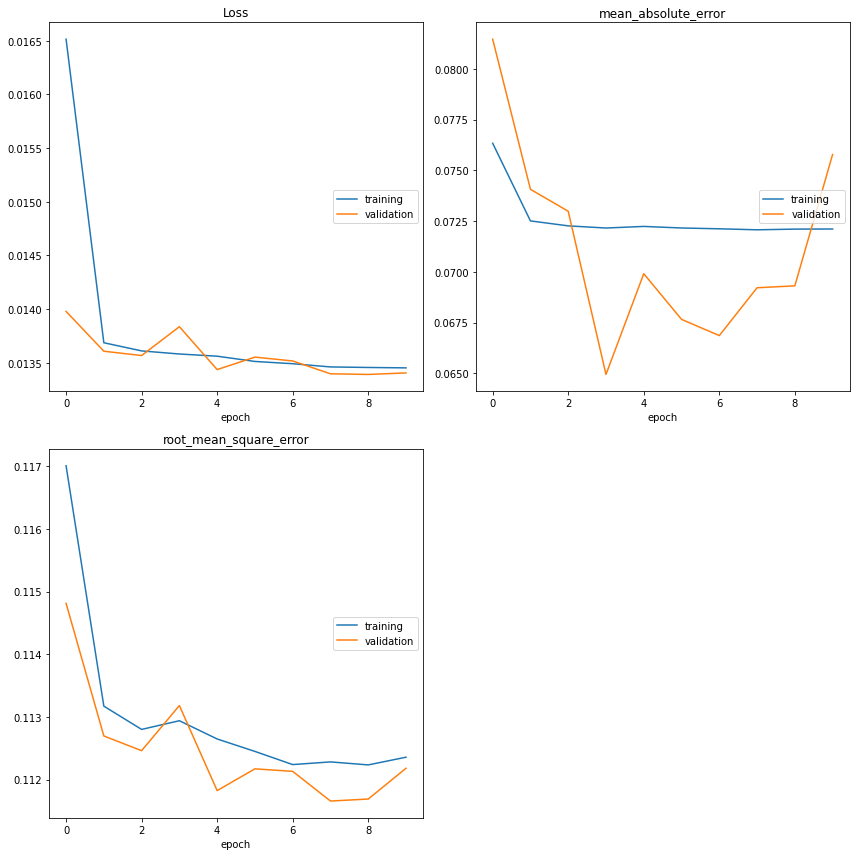

Loss
	training         	 (min:    0.013, max:    0.017, cur:    0.013)
	validation       	 (min:    0.013, max:    0.014, cur:    0.013)
mean_absolute_error
	training         	 (min:    0.072, max:    0.076, cur:    0.072)
	validation       	 (min:    0.065, max:    0.081, cur:    0.076)
root_mean_square_error
	training         	 (min:    0.112, max:    0.117, cur:    0.112)
	validation       	 (min:    0.112, max:    0.115, cur:    0.112)
2177/2177 [==============================] - 147s 67ms/step - loss: 0.0135 - root_mean_square_error: 0.1124 - mean_absolute_error: 0.0721 - val_loss: 0.0134 - val_root_mean_square_error: 0.1122 - val_mean_absolute_error: 0.0758


In [36]:
model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    verbose=1,
    shuffle=False,
    use_multiprocessing=True,
    workers=4,
    callbacks=[PlotLossesKeras(),model_checkpoint_callback]
)

In [37]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

545/545 [==============================] - 28s 50ms/step - loss: 0.0134 - root_mean_square_error: 0.1122 - mean_absolute_error: 0.0758
Test Evaluation:
	loss: 0.0134
	root_mean_square_error: 0.1122
	mean_absolute_error: 0.0758


In [39]:
k = 1000
song_lis = sorted(list(set(triplet["target"])))
user_lis = sorted(list(set(triplet["source"])))[:300]

edge_df_dic = {}
count = 0
for i in tqdm(song_lis, ncols = 100):
    edge_df_dic[count] = {"source" : user_lis[0], "target" : i, "A" : 0.0}
    count += 1
edges_df = pd.DataFrame.from_dict(edge_df_dic, orient='index')
labels_inp = edges_df["A"]

generator_inp = HinSAGELinkGenerator(
    user_song_graph, 256, num_samples, head_node_types=["user", "song"]
)
file_name = 'hinsage_recommendation_new.json'
if file_name in os.listdir():
    with open(file_name, "r") as fp:
        final_recommendation_dic = json.load(fp)
else:
    final_recommendation_dic = {}   

global_count = -1
for user_temp in tqdm(user_lis, ncols=100):
    global_count += 1

    if user_temp in final_recommendation_dic:
        continue

    edges_df["source"] = [user_temp for i in range(edges_df.shape[0])]

    edgelist_inp = list(edges_df[["source", "target"]].itertuples(index=False))
    
    inp_gen = generator.flow(edgelist_inp, labels_inp)
    user_pred = model.predict(inp_gen)

    user_song_dic = {}
    count = 0
    for i in range(len(song_lis)):
        user_song_dic[count] = {"song":song_lis[i],"rating":user_pred[i][0]}
        count += 1

    user_song_df = pd.DataFrame.from_dict(user_song_dic, orient='index')
    user_song_df = user_song_df.sort_values(by = ["rating"],ascending=False).reset_index(drop=True)
    top_k_songs = list(user_song_df["song"][:k])
    top_k_rating_pred = list(user_song_df["rating"][:k])
    final_recommendation_dic[user_temp] = [(top_k_songs[i], top_k_rating_pred[i]) for i in range(k)]

    if global_count % 10 == 0:
        with open(file_name, "w") as fp:
            json.dump(final_recommendation_dic, fp)

# final_recommendation_dic

100%|███████████████████████████████████████████████████████████| 300/300 [1:04:04<00:00, 12.82s/it]


In [ ]:
edge_df_dic = {}
temp = sorted(triplet["source"])[0]
count = 0
for i in tqdm(sorted(list(set(triplet["target"]))), ncols = 100):
    edge_df_dic[count] = {"source":temp,"target":i,"A":0.0}
    count += 1
edges_df = pd.DataFrame.from_dict(edge_df_dic, orient='index')
edgelist_inp = list(edges_df[["source", "target"]].itertuples(index=False))

# edgelist_inp

100%|████████████████████████████████████████████████████| 10099/10099 [00:00<00:00, 1021124.25it/s]


In [ ]:
se = list(user_song_df["song"][:10])
actual_songs = set(actual["target"])
for i in se:
    if i in actual_songs:
        print(i)

In [ ]:
# model.save("100")

In [ ]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  0.11508754220892597
	mean_absolute_error =  0.07147920132413783

Model Test set metrics:
	root_mean_square_error =  0.11306697785089959
	mean_absolute_error =  0.07094610584184327


In [ ]:
max(y_pred)

array([0.87920463], dtype=float32)

In [ ]:
h_true = plt.hist(y_true, bins=25, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=25, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

NameError: ignored

In [ ]:
# model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
# dataset = datasets.MovieLens()
# display(HTML(dataset.description))
# G, edges_with_ratings = dataset.load()


In [ ]:
# edges_with_ratings.head()

In [ ]:
# print(G.info())

METRIC

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
X = np.delete(X, 9, 1)

In [ ]:
X.shape

(10099, 78)

In [ ]:
enumerate(X)

In [ ]:
X[:,14:].shape

(10099, 64)

In [ ]:
song_song_similarity = cosine_similarity(X)

In [ ]:
song_song_similarity.shape

(10099, 10099)

In [ ]:
song_order=pd.read_csv("/content/drive/MyDrive/Metadata/song_order.txt",names=["song_id"], header=None)
song_order=list(song_order["song_id"])

In [ ]:
len(song_order)

10099

In [ ]:
actual.head()

,source,target
134365,00015189668691680bb1a2e58afde1541ec92ced,SOLFTVV12A6BD54FFC
134366,00015189668691680bb1a2e58afde1541ec92ced,SOSCIZP12AB0181D2F
134367,00015189668691680bb1a2e58afde1541ec92ced,SOWVBDQ12A8C13503D
134368,00015189668691680bb1a2e58afde1541ec92ced,SOGKMRO12AB0180FE0
134369,00015189668691680bb1a2e58afde1541ec92ced,SOIXXSG12A8C13C400


In [ ]:
k=10
actual_songs = list(actual["target"])
num=len(actual_songs)
mean_sim={}
count=0
for ind,row in user_song_df.iterrows():
    if count == k:
        break
    # print(ind)
    i=song_order.index(row["song"])
    sim=list(song_song_similarity[i])
    avg_sim=0
    for song in actual_songs:
        song_index=song_order.index(song)
        
        avg_sim+=sim[song_index]
        # print(avg_sim)
    mean_sim[row["song"]]=avg_sim/num  
    count+=1


In [ ]:
len(mean_sim)

10

In [ ]:
mean_sim
sum_1 = 0
for i in mean_sim:
     sum_1 += mean_sim[i]
    
sum_1/len(mean_sim)

0.8470274688060515

In [ ]:
np.argmin(song_song_similarity)

56634744

In [ ]:
A=song_song_similarity
ri, ci = A.argmin()//A.shape[1], A.argmin()%A.shape[1]
print(ri,ci)

5607 9651


In [ ]:
i=song_order.index("SOXTUWG12AB018A2E2")

In [ ]:
temp=song_song_similarity.reshape((-1,1))

In [ ]:
temp.shape

(101989801, 1)

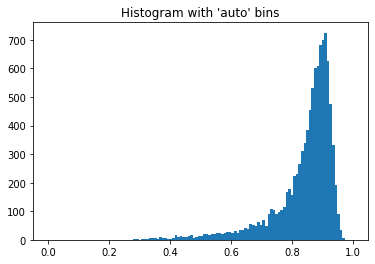

In [ ]:
_ = plt.hist(song_song_similarity[9651], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

NOT REALATED

In [ ]:

 
# returns JSON object as
# a dictionary
with open('/content/drive/MyDrive/User_Profile/data/user_profile_only_numes.json') as json_file:
    data = json.load(json_file)

In [ ]:
type(data)

dict

In [ ]:
data

{'996ef6faca152c921dc29c2f7f351802328ab375': [293.8396778378378,
  6.608108108108108,
  126.11902702702699,
  3.972972972972973,
  0.7323984462168538,
  0.5584856667611197,
  -6.065540540540541],
 'fdd25aad3e2aedda9b2a84501fe50a7c12ad44ee': [217.46577000000005,
  7.575757575757576,
  137.73078787878788,
  3.909090909090909,
  0.7558210476969838,
  0.4920806547830791,
  -8.581242424242426],
 '77ba684cffd51402802f3908fa044a01d8cc15d6': [212.08442145695363,
  2.2847682119205297,
  129.85111258278147,
  3.966887417218543,
  0.6484617528079625,
  0.5519380434130778,
  -6.84046357615894],
 '875e9c3b7d5e812287c1fce41191a1aed9200f5f': [176.69289507042254,
  2.9859154929577465,
  142.01345070422536,
  4.0,
  0.8190373944787047,
  0.5892568236286786,
  -6.867746478873239],
 'e44ae4e3d173ddc2d28463a47b447a0113ce24e0': [291.5483360869565,
  5.808695652173913,
  95.50100869565219,
  4.086956521739131,
  0.741691005050166,
  0.6334350888869251,
  -9.57978260869565],
 '8b5399c2b10988e181ddc0546572a5a

In [ ]:
data[0]

'00015189668691680bb1a2e58afde1541ec92ced'

In [ ]:
# df = pd.DataFrame(data.items(),columns =['user_id',"0","1","2","3","4","5","6"])
df=pd.DataFrame.from_dict(data,orient='index')

In [ ]:
df.head()


,0,1,2,3,4,5,6
00015189668691680bb1a2e58afde1541ec92ced,242.801906,4.987654,133.178111,3.703704,0.739255,0.511190,-11.781037
0007ccf17b03de70b8642e2548fe4c9be3b9e560,457.605723,10.069767,130.077279,3.527132,0.826769,0.744253,-6.039109
000923be99eda0ecf81ca3351794f80dd758f696,300.456264,6.304348,165.051587,3.945652,0.536116,0.486225,-22.269489
0015fa97e2a0ec2eaa252b9d892f8bac269e8c8b,249.265723,4.610390,134.565844,2.753247,0.665777,0.549427,-7.756377
0017f8c0a7facc540d611a7e56d2bcb592a82e17,231.961772,6.823529,145.392265,4.000000,0.761367,0.543374,-5.691873


In [ ]:
df=df.sort_index()

In [ ]:
df.to_csv("/content/drive/MyDrive/User_Profile/data/user_profile_only_numes.csv",index=True)

In [ ]:
npy=df.to_numpy()

In [ ]:
npy.shape

(13624, 7)

In [ ]:
npy[0]

array([242.80190593,   4.98765432, 133.17811111,   3.7037037 ,
         0.73925531,   0.51118999, -11.78103704])

In [ ]:
np.save("/content/drive/MyDrive/User_Profile/data/user_profile_vectors_only_numes.npy",npy)